In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics


import warnings

In [ ]:
warnings.filterwarnings("ignore")

# Data Cleaning and preview

In [ ]:
#Import Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train=train.drop('Unnamed: 0', axis = 'columns')
test=test.drop('Unnamed: 0', axis = 'columns')

In [ ]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x="type", data=train, ax=axs[0])
axs[0].set_title("Train ", fontsize=30)
sns.countplot(x="type", data=test, ax=axs[1])
axs[1].set_title("Test", fontsize=30)
plt.show()

In [ ]:
def summary(data):
    # Get stats
    output_data = data.describe().transpose()
    # Count of NANs
    output_data['Count_NaNs'] = (data.shape[0] - output_data['count'])/ data.shape[0] * 100   
    # Count unique values
    output_data['Count_Distincts'] = data.apply(lambda x: len(pd.unique(x)), axis=0)  
    return output_data
summary(train)

In [ ]:
# Verification NA
def compute_missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    #Affiche que les variables avec des na
    print (missing_data[(percent>0)],'\n' )
    return missing_data[(percent>0)].index.tolist()


In [ ]:
compute_missing_values(train)

In [ ]:
print(f"Train data has {train.isna().sum().sum()} NAs")
print(f"Test data has {test.isna().sum().sum()} NAs")

In [ ]:
duplicateRows = train[train.duplicated()]
duplicateRows

In [ ]:
y_train = train['type']

In [ ]:
y_train

# Counting of sample subtypes

In [ ]:
y_train.value_counts().plot(kind='bar')

In [ ]:
train.groupby("type").size().reset_index().rename(columns={0:"Count"})

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
train["type"] = le.fit_transform(train["type"])
test["type"] = le.fit_transform(test["type"])
#train = pd.merge(train, on="samples")

#test = pd.merge(test, on="samples")

In [ ]:
train["type"]


In [ ]:
train.groupby("type").size().reset_index().rename(columns={0:"Count"})

In [ ]:
# split data into X and y
X_train = train.drop(columns=["samples", "type"])
y_train = train["type"]
X_test = test.drop(columns=["samples", "type"])
y_test = test["type"]

In [ ]:
X_train.head()

In [ ]:
# Features scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

In [ ]:
train.iloc[:,2:] 

In [ ]:
X_train_scaled

# Dimentionality reduction and clusterisation

In [ ]:
reduced_train = PCA().fit_transform(X_train_scaled)
kmeans = KMeans(n_clusters=4, n_init=20)
kmeans.fit(train.iloc[:,2:])

In [ ]:
sns.scatterplot(x=reduced_train[0], y=reduced_train[1], hue=kmeans.labels_)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
pca = PCA()
pca.fit_transform(X_train_scaled)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance / total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1   
print(k, " features explain around 90% of the variance. From 22283 features to ", k, sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(1, k + 1), var_exp, color="brown")
plt.xlabel("Cumulutive explained variance", fontsize=18)
plt.ylabel("Number of components", fontsize=18)
plt.xlim((0.5, k + 1))
plt.show()

 Remark that we can take approximately 57 PC for downstream analysis

# Machine Learning Models

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc 
from sklearn.metrics import confusion_matrix,accuracy_score
max_depth_best = []
for i in range(1,20):
    clf = rfc(max_depth=i, random_state=0)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    max_depth_best.append([i, accuracy_score(y_test, y_pred)])
max_depth = pd.DataFrame(max_depth_best, columns= ["max_depth", "Accuracy"])
max_depth

In [ ]:
# FINDING THE BEST N_ESTIMATOR
n_estimators=[]
for i in range(10,100):
    clf= rfc(max_depth= 4, n_estimators=i, random_state=0)
    clf.fit(X_train_scaled, y_train)
    y_pred= clf.predict(X_test_scaled)
    n_estimators.append([i, accuracy_score(y_test, y_pred)])

In [ ]:
#The Optimal n_estimator
n_estimate = pd.DataFrame(n_estimators, columns= ["n_estimator", "Accuracy"])
n_estimate.loc[n_estimate["Accuracy"].idxmax()]

From the series above, we see that 0.8 is the highest score and the best n_estimator is 37.

# Training the random Forest Model With The Hyperparameters Obtained Above

In [ ]:
rf_model = rfc(max_depth=4, n_estimators= 37, random_state=0)
rf_model.fit(X_train_scaled, y_train)

#Predicting on Testing Set

y_pred= rf_model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

## Confusion Matrix an Roc Curve

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print ("\nClassification report :\n", metrics.classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred, labels= rf_model.classes_)
ConfusionMatrixDisplay(conf_mat, display_labels=rf_model.classes_).plot()
print('Confusion Matrix\n')


## Random Forest Observations
The model is having a small problem with separating between Ovarian_Tumor_Serous and Ovarian_Tumor_Endometrioid

In [ ]:
# ROC curve
rf_predicted_probs = rf_model.predict_proba(X_test_scaled)
from sklearn.metrics import roc_curve

fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, rf_predicted_probs[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, rf_predicted_probs[:,i], pos_label=i)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# plotting  
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

#plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
#plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
#plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
#plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class 3 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

plt.show()

## Feature Importances

In [ ]:
print(f"Quantity of features with 0 importance: {(rf_model.feature_importances_ ==0).sum()}")

In [ ]:
mask = (rf_model.feature_importances_ >0.006)
importances = rf_model.feature_importances_[mask]
feature_names = train.columns.values[:22283][mask]

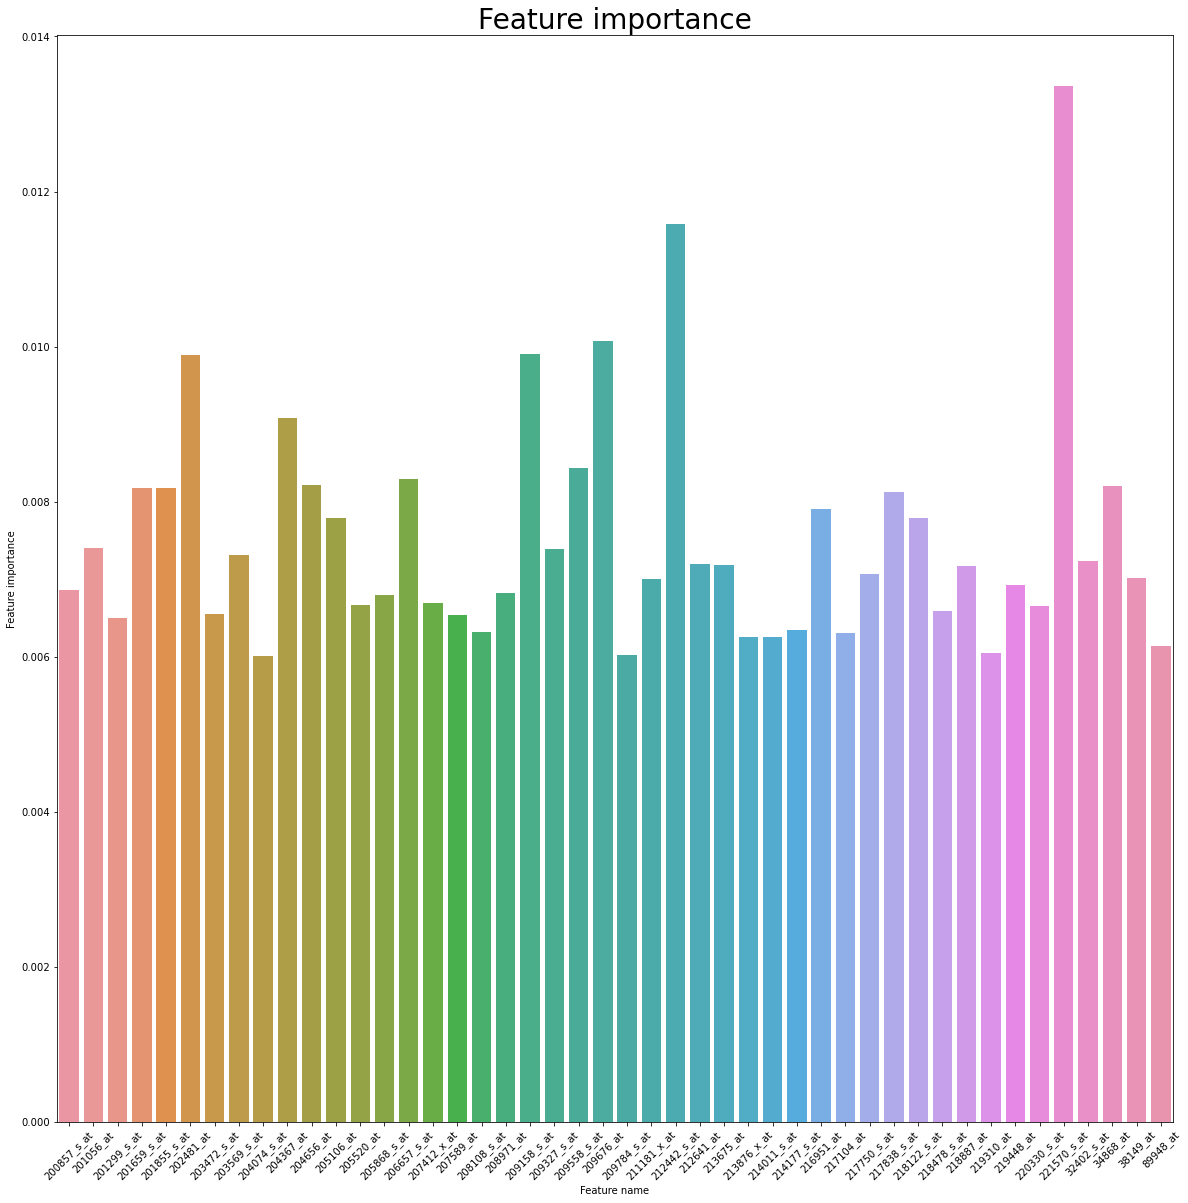

In [62]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.barplot(x=feature_names, y=importances)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.title("Feature importance", fontsize=28)
ax.set_xticklabels(feature_names, rotation = 45)
plt.show()

In [64]:
print(f"Also accuracy score is: {metrics.accuracy_score(y_test, y_pred)}")

Also accuracy score is: 0.8


# K Nearest Neighbors Model

In [75]:
from sklearn.neighbors import KNeighborsClassifier as knn
neighbors = []

for i in range(1,20):
    kclass= knn(n_neighbors=i)
    kclass.fit(X_train, y_train)
    y_pred= kclass.predict(X_test_scaled)
    neighbors.append([i, accuracy_score(y_test, y_pred)])
neighbors = pd.DataFrame(neighbors, columns= ["n_neighbors", "Accuracy"])
neighbors.head()

,n_neighbors,Accuracy
0,1,0.40
1,2,0.30
2,3,0.40
3,4,0.50
4,5,0.65


## LogisticRegression

In [82]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train_scaled, y_train) 
lr_f1_score = metrics.f1_score(y_test, clf.predict(X_test_scaled), average="micro")
lr_f1_score

0.8000000000000002

# Ensembling The Models

In [71]:
rf_f1_score = metrics.f1_score(y_test, rf_model.predict(X_test_scaled), average="micro")
knn_f1_score = metrics.f1_score(y_test, kclass.predict(X_test_scaled), average="micro")
lr_f1_score = metrics.f1_score(y_test, clf.predict(X_test_scaled), average="micro")

In [72]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[("rf", rf_model), ("knn", kclass), ("lr", clf)],
                                        voting="soft")

In [73]:
ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=4,
                                                     n_estimators=37,
                                                     random_state=0)),
                             ('knn', KNeighborsClassifier(n_neighbors=19)),
                             ('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=0))],
                 voting='soft')

Validation f1-score of Ensemble Classifier is 0.85

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.78      0.88      0.82         8
           2       1.00      0.50      0.67         2
           3       0.89      1.00      0.94         8

    accuracy                           0.85        20
   macro avg       0.92      0.72      0.77        20
weighted avg       0.87      0.85      0.84        20



Text(0.5, 1.0, 'CONFUSION MATRIX')

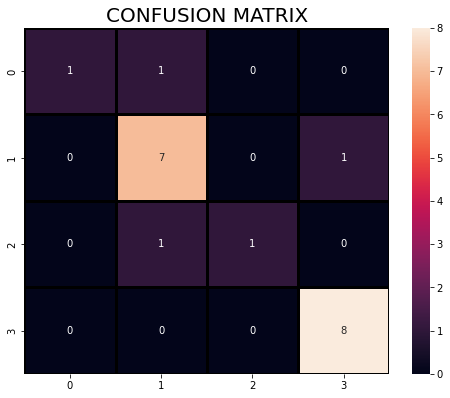

In [78]:
ens_prediction = ensemble.predict(X_test_scaled)
f1_score = metrics.f1_score(y_test, ens_prediction, average="micro")
print('Validation f1-score of Ensemble Classifier is', f1_score)
print ("\nClassification report :\n", metrics.classification_report(y_test, ens_prediction))

# Confusion matrix
plt.figure(figsize=(18, 14))
plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, ens_prediction), annot=True, fmt = "d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)



# Comparison of the models

In [81]:
model_scores = [rf_model.score(X_test_scaled, y_test), 
                kclass.score(X_test_scaled, y_test), 
               clf.score(X_test_scaled, y_test),
               ensemble.score(X_test_scaled, y_test)]
models = pd.DataFrame({"Model": ["Random Forest", "KNN", "Logistic", "Ensemble"],
              "Accuracy": model_scores})
models

,Model,Accuracy
0,Random Forest,0.80
1,KNN,0.75
2,Logistic,0.80
3,Ensemble,0.85


As we can see Ensemble have shown the best performance. 



# Conclusion

Results:

RandomForest and LogisticRegression have shown a good results: f1-score was 0.8 and other metrics were good too.
Also we got the most important genes for cancer type distinguishing.
Then we built Ensemble classifier and it have performed noce results (f1-score was 1)

## Comments


#### Task 1

Machine learning methods are extensively used in the bio-medical field to successfully distinguish among cancer subtypes or normal versus cancer samples. 
In this dataset we are handling a supervised learning techniques to classify cancer subtypes. The data containes 4 classes relatively balanced. 
Checking the training set, we notice that we don't have to clean the data for duplicates and missing values.

challenges:

 1- Looking at the summary statistics, we can see that the gene expression values or features values have slightly different ranges. 
 
 2- Looking at the number of features in the data, we can comfirm that gene expression data provided by microarray technology is of enormous size i.e. high dimensional which makes analysis a very challenging task. 

Other challenges could be discovered as we do a more detailed analysis of the data, such as checking the data for high correlation between features or for collinearity. Another challenge could also be having outliers in the data, it is sometimes important to check for anomalies in the data especially that the dataset at out disposal is high dimensional, therfore prone to anomalies.



#### Task 2 and 3

As a solution to point n.o 1, we need to preprocess the data, I would suggest to change the values of the columns to a common scale, without distorting differences in the ranges of values using the classic standard scaler. 

As a solution to point n.o 2, I would that the gene selection is an essential process which removes the problem of dimensionality by removing irrelevant and unwanted genes from gene expression data. Different approches were suggested in the literature. One could think of standard wrapper feature selection approches. However, these techniques are time consuming and require evaluating multiple models using procedures that add and/or remove predictors to find the optimal feature combination that maximizes model performance which is computationally intensive. Another approach is using filter techniques as these methods are faster and less computationally expensive than wrapper methods. When dealing with high-dimensional data, it is computationally cheaper to use filter methods. Some of these techniques are Information Gain/ Fisher's score/ Chi Square test to name a few (checkout https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/ ).

Another approach designed specifically for gene expression data is ReliefF model families. The main benefit of ReliefF algorithms is that they identify feature interactions without having to exhaustively check every pairwise interaction, thus taking significantly less time than exhaustive pairwise search. Check the following links https://pypi.org/project/ReliefF/ and https://en.wikipedia.org/wiki/Relief_(feature_selection).


As a last suggestion, we can use the classic dimensionality reduction techniques such as Principal Component Analysis PCA or LDA.

For a probable issue of high variance and multicollinearity, mentioned above, we can check a sequence of columns (subsets and preserve the order as apparently the order is important in forming the RNA) and do a correlation analysis on those... (heatmap of the pairwise correlations/ VIF Analysis, etc...)


For Modelling, we tried some classification algorithms to differentiate between cancer subtypes such as random forest, k-nearest neighbor, logistic regression and we finally put them together in order to get a better performance. To the best of our knowledge, no classification method universally outperforms all the others. However, Xgboost and other gradient boosting models can sometimes performan better than other classifiers as each successive model attempts to correct for the shortcomings of the combined boosted ensemble of all previous models.


Interesting papers for your reference : 

- https://www.eurekaselect.com/article/76470#:~:text=The%20gene%20expression%20data%20provided,genes%20from%20gene%20expression%20data.
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3873740/

